In [5]:
#from midir import w1w2_condition
from tqdm import tqdm

import numpy as np

import matplotlib
import matplotlib.pyplot as plt

import astropy
from astropy.io import fits
from astropy.table import Table
from astropy.timeseries import TimeSeries
from astropy.time import Time
from astropy.timeseries import TimeSeries, aggregate_downsample
from astropy.coordinates import match_coordinates_sky as coords

from PIL import Image

import warnings
warnings.filterwarnings('ignore')

from mid_IR_variables import fileIO_processing as fp
from mid_IR_variables import lightcurve_processing as lp
from mid_IR_variables import ZTF_lightcurve_processing as zlp

from sklearn.gaussian_process import GaussianProcessRegressor, kernels

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams.update({'font.size': 22})
matplotlib.rc('font',**{'family':'serif','serif':['Times']})
matplotlib.rc('text', usetex=True)

SAVE_FILEPATH = 'C:/Users/paiaa/Documents/Research/Blanton Lab/Midir Variables/Figures/'
IMPORT_FILEPATH ='C:/Users/paiaa/Documents/Research/Blanton Lab/Midir Variables/'

mnsa_hdu, manga_wise_hdu, pipe3d_hdu = fp.import_manga(6, 1, 1)
mnsa, mwv, pipe3d = mnsa_hdu.data, manga_wise_hdu.data, pipe3d_hdu.data

In [3]:
from astropy.convolution import Gaussian1DKernel, convolve

import math

import scipy.stats as stats
import scipy.signal as signal
import scipy.optimize as optimize
from scipy.integrate import quad

# def hat(x, width, amp=1):
#     y=x.copy()
#     x2 = x - x.mean()
#     y[(x2<-width) | (x2>width)]=0
#     y[(x2>-width) & (x2<width)]=1
#     return amp * y

# def convolve(kernel, ts, mode='valid'):

#     kernel_size = len(kernel)

#     func = ts['mag']

#     conv = np.convolve(kernel, func, mode=mode)
#     t_conv = ts['time'].to_value('decimalyear')[(kernel_size-1)//2:-(kernel_size-1)//2]
    
#     return conv, t_conv

def convolve(kernel, ts, width):
    t_opt = ts['time'].to_value('decimalyear')
    mags = ts['mag']

    convolution = np.array([])

    #kernel_index_width = np.count_nonzero(kernel)

    t_start = t_opt[0]+width/2
    t_end = t_opt[-1]-width/2

    t_start_ind = np.argmin(np.abs(t_opt-t_start))
    t_end_ind = np.argmin(np.abs(t_opt-t_end))

    for i in range(t_start_ind, t_end_ind):
        lower_bound = t_opt[i]-width/2
        upper_bound = t_opt[i]+width/2

        t_lb_ind = np.argmin(np.abs(t_opt-lower_bound))
        t_ub_ind = np.argmin(np.abs(t_opt-upper_bound))

        integral = 0

        w = t_ub_ind - t_lb_ind

        for ind, j in enumerate(range(t_lb_ind, t_ub_ind)):

            integral += mags[j] * kernel[kernel.size//2-w//2+ind]
            #print(kernel.size//2-w//2+ind)
        convolution =np.append(convolution, integral)

    t_conv = t_opt[t_start_ind:t_end_ind]
    return convolution, t_conv


def hat(x, width):
    y=x.copy()
    x2 = x - x.mean()
    y[(x2<-width) | (x2>width)]=0
    y[(x2>-width) & (x2<width)]=1

    return y/y.sum()

In [6]:
pifu=  '10223-3701'#'8466-3704' #'8593-12705' #'8561-3704' #'8612-1901' #'8619-12702' #'9870-9101'#'9487-3702' #'8612-1901'#'8091-9101' #'7977-9101' #'12071-12703' #'11833-3702'  #'8553-1901' 
test = lp.generate_combined_lightcurve(pifu=pifu)

poly_subtracted_obj_p, fit, fitted_poly = lp.polyfit_lightcurves(test, deg=10)
test_gp, llh, hyperparams, cov = lp.GP(poly_subtracted_obj_p, kernel_num=3, lengthscale=(0.95, 1.05))
gp_fitted_poly =lp.make_polynomial(test_gp, fit)

wise_obj_p1 = fp.process_wise(pifu, mwv, band=1)
wise_obj_p2 = fp.process_wise(pifu, mwv, band=2)

using padded times


In [7]:
test_gp['mag']+=gp_fitted_poly

In [8]:
hyperparams

3.57**2 * RBF(length_scale=0.95) + WhiteKernel(noise_level=0.672)

Text(0.5, 0, 'date')

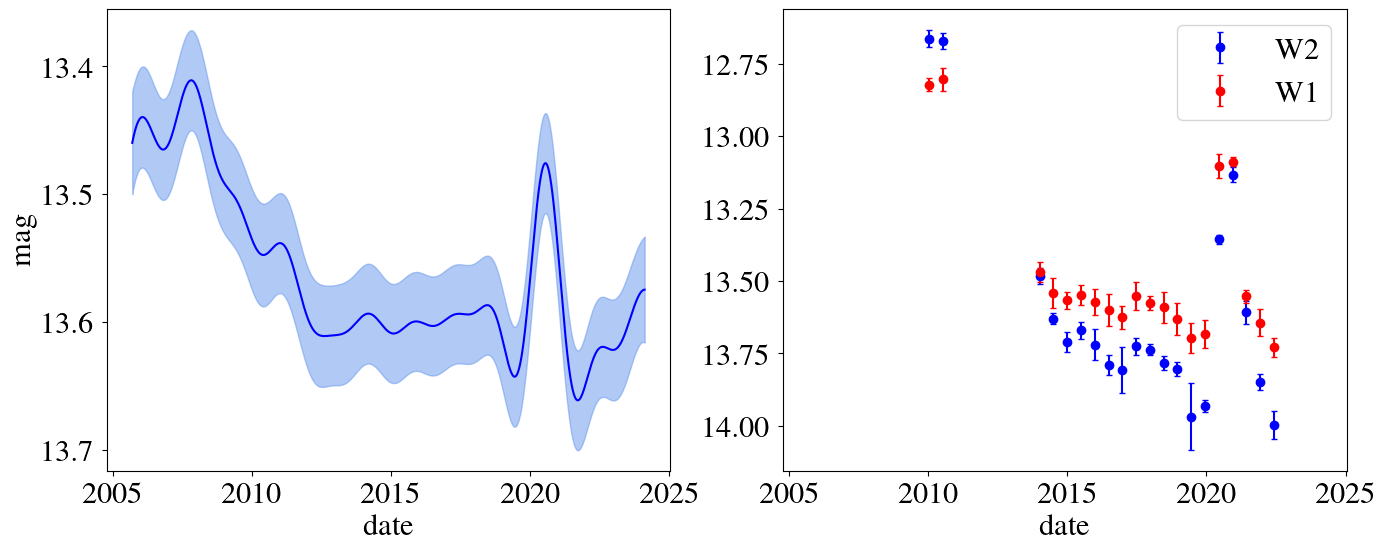

In [6]:
fig, ax = plt.subplots(figsize=(16,6), ncols=2)

ax[0].plot(test_gp['time'].to_value('decimalyear'), test_gp['mag'], c='blue')
ax[0].fill_between(test_gp['time'].to_value('decimalyear'), test_gp['mag']-test_gp['mag_err'], test_gp['mag']+test_gp['mag_err'], color='cornflowerblue', alpha=0.5)

ax[0].invert_yaxis()
ax[0].set_ylabel('mag')
ax[0].set_xlabel('date')

ax[1].errorbar(wise_obj_p2['time'].to_value('decimalyear'), wise_obj_p2['mag'], yerr=wise_obj_p2['mag_err'], linestyle='none', marker='o', capsize=2, color='b', label='W2')
ax[1].errorbar(wise_obj_p1['time'].to_value('decimalyear'), wise_obj_p1['mag'], yerr=wise_obj_p1['mag_err'], linestyle='none', marker='o', capsize=2, color='r', label='W1')

ax[1].legend()
ax[1].invert_yaxis()
ax[1].sharex(ax[0])
ax[1].set_xlabel('date')

In [122]:
t_opt = test_gp['time'].to_value('decimalyear')


tophat_width, tophat_amp =2, 1
x = np.linspace(t_opt[0], t_opt[-1], t_opt.size)

h = hat(x, tophat_width)
g = 1e-1 * stats.norm.pdf(x, loc=t_opt.mean(), scale=tophat_width)

conv1, t_conv1 = convolve(h, test_gp, tophat_width)
conv2, t_conv2 = convolve(g, test_gp, tophat_width)

In [119]:
h

array([0., 0., 0., ..., 0., 0., 0.])

Text(0.5, 0, 'date')

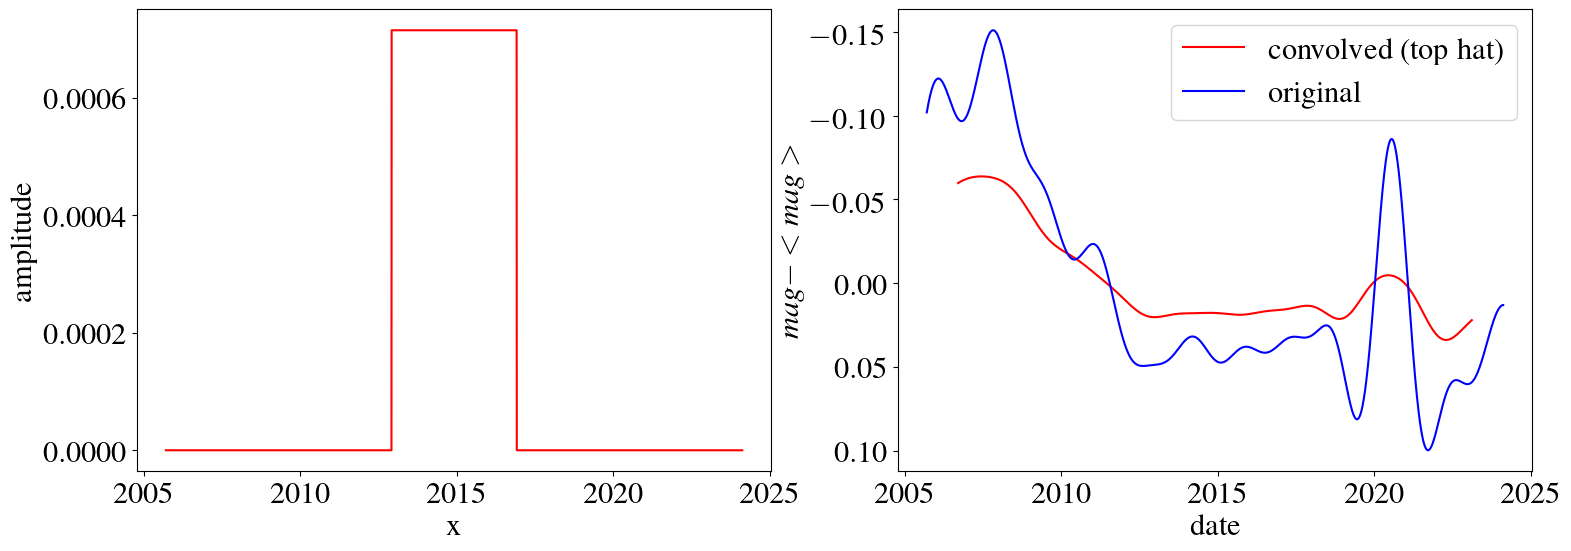

In [123]:
fig, ax = plt.subplots(figsize=(18,6), ncols=2)

ax[0].plot(x, h, c='r')
#ax[0].plot(x, g, c='k')

ax[0].set_ylabel('amplitude')
ax[0].set_xlabel('x')

ax[1].plot(t_conv1, conv1-conv1.mean(), c='r', label='convolved (top hat)')
#ax[1].plot(t_conv2, conv2-conv2.mean(), c='k', label='convolved (gaussian)')
ax[1].plot(test_gp['time'].to_value('decimalyear'), test_gp['mag']-test_gp['mag'].mean(), c='b', label='original')

ax[1].legend()
ax[1].invert_yaxis()
ax[1].set_ylabel(r'$mag - <mag>$')
ax[1].set_xlabel('date')

In [9]:
def chisqfunc(x, args):
    amp, const = x[0], x[1]
    lag, c, t_conv, wise = args[0], args[1], args[2], args[3]
    
    t_wise = wise['time'].to_value('decimalyear')
    inds = np.abs(t_wise[:, None] - (t_conv[None, :]+lag)).argmin(axis=-1)

    opt_mags = c[inds] #- test_gp['mag'][inds].mean()
    ir_mags = wise['mag']# - wise_obj_p['mag'].mean()
    err =  test_gp['mag_err'][inds]
    
    model = amp * opt_mags + const

    chisq = np.sum(((ir_mags-model)/err)**2)

    return chisq

In [10]:
lags = np.linspace(0.01, 2, 100) #np.arange(0.01, 2, 0.027)
amps, consts = np.array([]), np.array([])
chisq, rmse = np.array([]), np.array([])
tmags, mags, convolutions, conv_times = [], [], [], []

for i, lag in enumerate(lags):
    print(i)
    tophat_width, tophat_amp = lag/2, 1

    x = np.linspace(t_opt[0], t_opt[-1], t_opt.size)
    h = hat(x, width=tophat_width, amp=tophat_amp)

    c, t_conv = convolve(h, test_gp, tophat_width)
 
    t_wise = wise_obj_p1['time'].to_value('decimalyear')
    inds = np.abs(t_wise[:, None] - (t_conv[None, :]+lag)).argmin(axis=-1)

    model = optimize.minimize(chisqfunc, x0=[1, 1], args=[lag, c, t_conv, wise_obj_p1])
    
    #rmse = np.append(rmse, np.sqrt(np.mean(np.square(wise_obj_p['mag']-c[inds]))))
    convolutions.append(c)
    conv_times.append(t_conv)
    mags.append(c[inds])
    tmags.append(t_conv[inds])
    amps = np.append(amps, model.x[0])
    consts = np.append(consts, model.x[1])
    chisq = np.append(chisq, model.fun)




0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38


KeyboardInterrupt: 

In [ ]:
i = np.argsort(chisq[:60])[0]
l, a, const, c, t_conv = lags[i], amps[i], consts[i], convolutions[i], conv_times[i]

l, a, const

(0.23111111111111113, 0.13845812037331232, -61.79459164283324)

Text(0, 0.5, 'chi squared value')

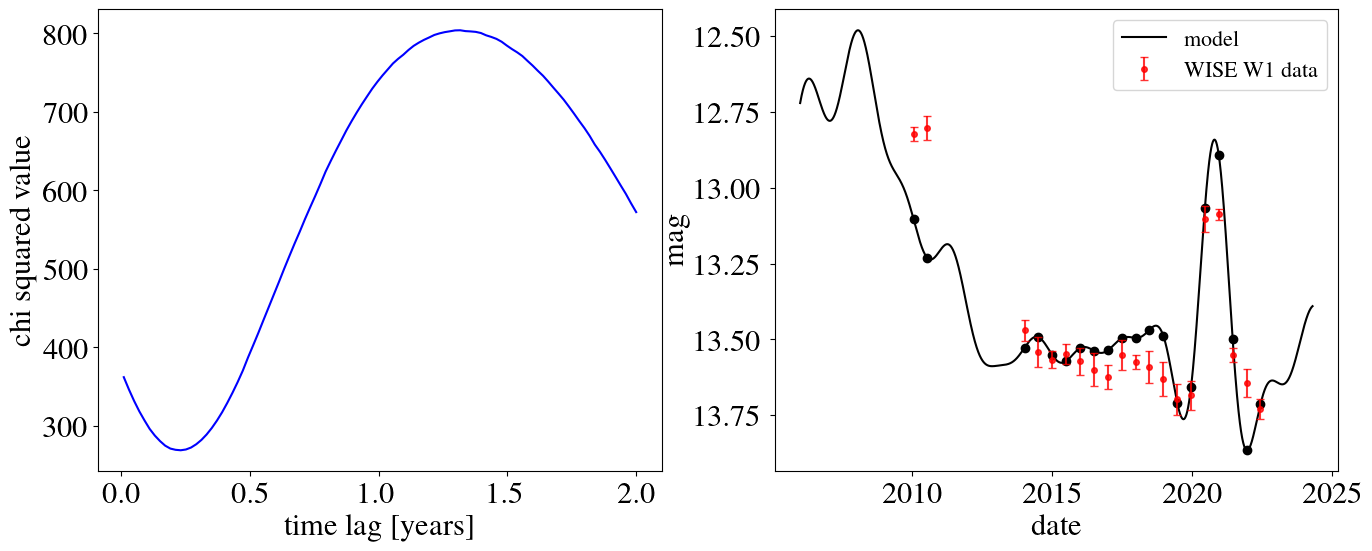

In [ ]:
fig, ax = plt.subplots(figsize=(16,6), ncols=2)

ax[1].errorbar(wise_obj_p1['time'].to_value('decimalyear'), wise_obj_p1['mag'], yerr=wise_obj_p1['mag_err'], ls='none', capsize=3, marker='o', ms=4, c='r', alpha=0.8, label='WISE W1 data')
ax[1].plot(t_conv+l, a*c+const, c='k', zorder=-1, label='model')
#ax.plot(test_gp['time'].to_value('decimalyear'), test_gp['mag'], c='b')
ax[1].scatter(tmags[i]+l, a*mags[i]+const, c='k')
#ax[1].plot(test_gp['time'].to_value('decimalyear'), test_gp['mag'], c='blue', label='GP fit')

ax[1].invert_yaxis()
ax[1].legend(fontsize=16)

ax[1].set_xlabel('date')
ax[1].set_ylabel('mag')

ax[0].plot(lags, chisq, c='b')
#ax[0].plot(lags, rmse, c='b')

ax[0].set_xlabel('time lag [years]')
ax[0].set_ylabel('chi squared value')

In [ ]:
lags = np.linspace(0.01, 2, 100) #np.arange(0.01, 2, 0.027)
amps, consts = np.array([]), np.array([])
chisq, rmse = np.array([]), np.array([])
tmags, mags, convolutions, conv_times = [], [], [], []

for i, lag in enumerate(lags):
    print(i)
    tophat_width, tophat_amp = lag/2, 1

    x = np.linspace(t_opt[0], t_opt[-1], t_opt.size)
    h = hat(x, width=tophat_width, amp=tophat_amp)

    c, t_conv = convolve(h, test_gp, tophat_width)
 
    t_wise = wise_obj_p2['time'].to_value('decimalyear')
    inds = np.abs(t_wise[:, None] - (t_conv[None, :]+lag)).argmin(axis=-1)

    model = optimize.minimize(chisqfunc, x0=[1, 1], args=[lag, c, t_conv, wise_obj_p2])
    
    #rmse = np.append(rmse, np.sqrt(np.mean(np.square(wise_obj_p['mag']-c[inds]))))
    convolutions.append(c)
    conv_times.append(t_conv)
    mags.append(c[inds])
    tmags.append(t_conv[inds])
    amps = np.append(amps, model.x[0])
    consts = np.append(consts, model.x[1])
    chisq = np.append(chisq, model.fun)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [ ]:
i = np.argsort(chisq[:60])[0]
l, a, const, c, t_conv = lags[i], amps[i], consts[i], convolutions[i], conv_times[i]

l, a, const

(0.35171717171717176, 0.11514606673154605, -83.41108148689314)

Text(0, 0.5, 'chi squared value')

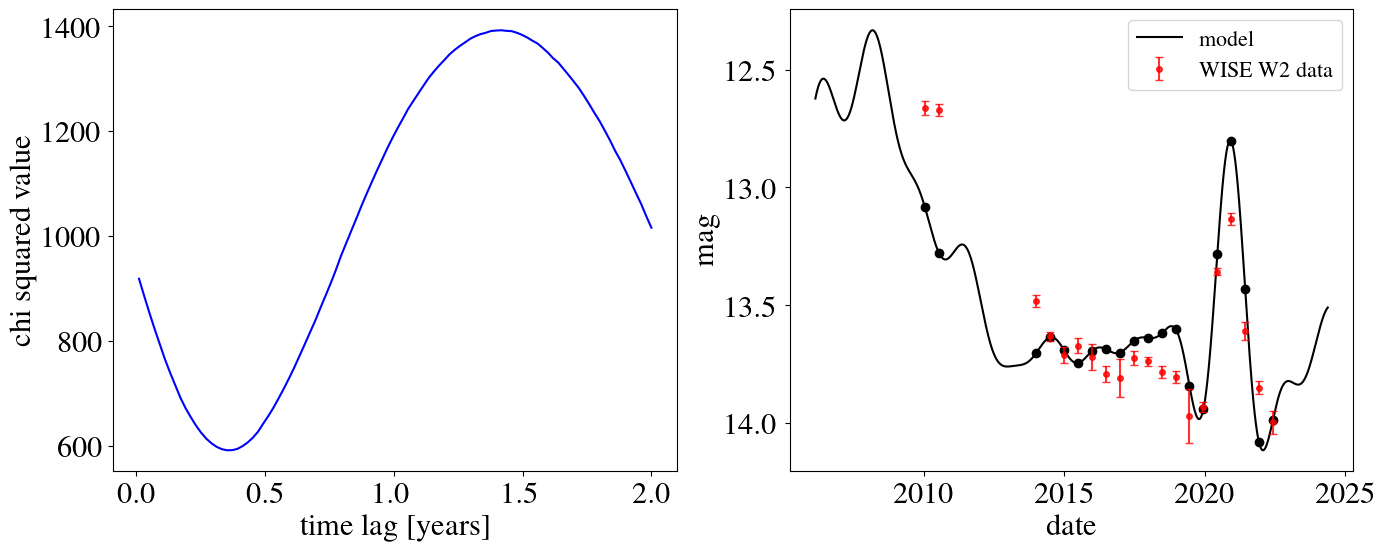

In [ ]:
fig, ax = plt.subplots(figsize=(16,6), ncols=2)

ax[1].errorbar(wise_obj_p2['time'].to_value('decimalyear'), wise_obj_p2['mag'], yerr=wise_obj_p2['mag_err'], ls='none', capsize=3, marker='o', ms=4, c='r', alpha=0.8, label='WISE W2 data')
ax[1].plot(t_conv+l, a*c+const, c='k', zorder=-1, label='model')
#ax.plot(test_gp['time'].to_value('decimalyear'), test_gp['mag'], c='b')
ax[1].scatter(tmags[i]+l, a*mags[i]+const, c='k')
#ax[1].plot(test_gp['time'].to_value('decimalyear'), test_gp['mag'], c='blue', label='GP fit')

ax[1].invert_yaxis()
ax[1].legend(fontsize=16)

ax[1].set_xlabel('date')
ax[1].set_ylabel('mag')

ax[0].plot(lags, chisq, c='b')
#ax[0].plot(lags, rmse, c='b')

ax[0].set_xlabel('time lag [years]')
ax[0].set_ylabel('chi squared value')

In [ ]:
lags = np.linspace(0.01, 2, 100)
t_opt = test_gp['time'].to_value('decimalyear')
t_wise = wise_obj_p2['time'].to_value('decimalyear')
wise_mags = wise_obj_p2['mag']

ccf = np.array([])
for i, lag in enumerate(lags):
    inds = np.abs(t_wise[:, None] - (t_opt[None, :]+lag)).argmin(axis=-1)

    
    opt_mags = test_gp['mag'][inds] - np.mean(test_gp['mag'][inds])
    opt_times = t_opt[inds]

    ir_mags = wise_mags - np.nanmean(wise_mags)
    
    cross_corr = np.correlate(opt_mags, wise_mags, mode='valid')
    ccf = np.append(ccf, cross_corr)


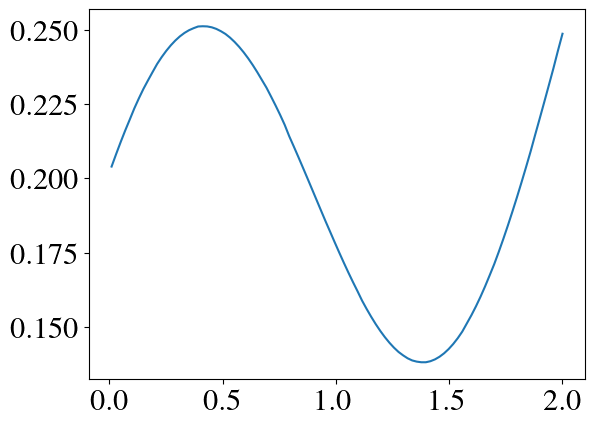

In [ ]:
plt.plot(lags, ccf)

In [ ]:
np.argmax(ccf)
lags[20]

0.41202020202020206

In [ ]:
inds = np.abs(t_wise[:, None] - (t_opt[None, :])).argmin(axis=-1)


opt_mags = test_gp['mag'][inds] - np.mean(test_gp['mag'][inds])
opt_times = t_opt[inds]

corr = np.correlate(opt_mags, wise_mags, mode='full')

In [43]:
x = np.linspace(t_opt[0], t_opt[-1], 1000)
h = hat(x, 1, 1)
h = h/h.sum()

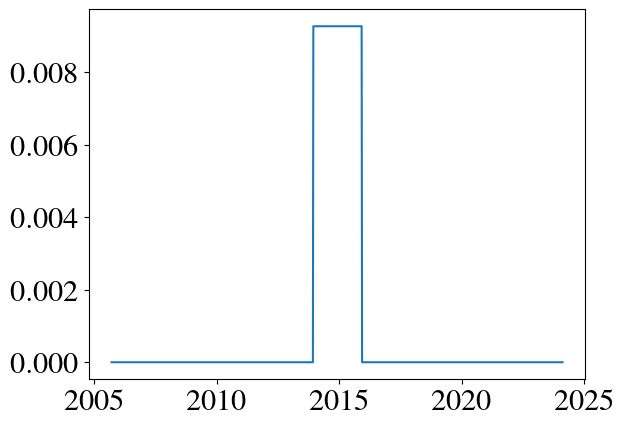

In [44]:
plt.plot(x, np.convolve(h, signal.unit_impulse(h.size, h.size//2), mode='same'))

In [101]:
def gaussian(x, sigma):
    return np.exp(-(x/sigma)**2/2) 

#convolution
def smooth(y, width, box_pts): 
    x = (np.linspace(-1.01*width, 1.01*width,box_pts+2)) #Gaussian centred on 0
    #std_norm = 3. #3. is an arbitrary value for normalizing the sigma
    #sigma = box_pts/std_norm 
    #integral = quad(gaussian, x[0], x[-1], args=(sigma))[0]
    box = hat(x, width, 1)
    box /= box.sum()
    plt.scatter(x, box)
    y_smooth = np.convolve(y,box,mode='same')
    return y_smooth

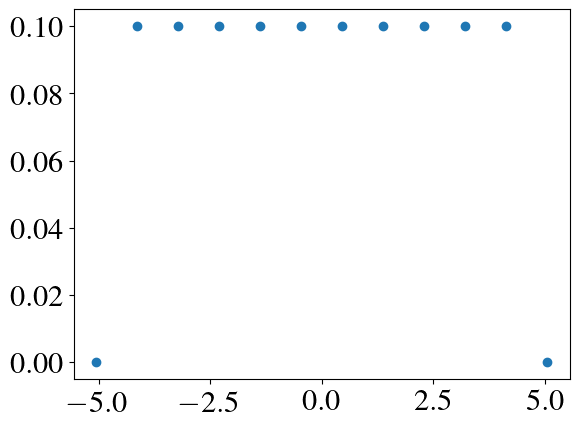

In [103]:
box_size = 10

w = 5
y_smooth = smooth(test_gp['mag'], w, box_size)

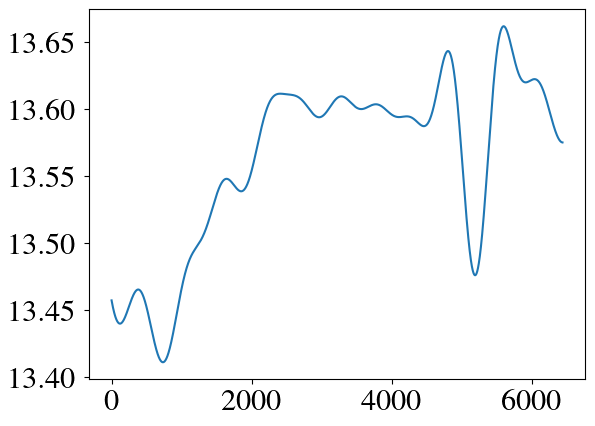

In [75]:
#plt.plot(y)

plt.plot(y_smooth[10:])

In [79]:
0.3//np.mean(np.diff(t_opt))

104.0